# SOURCE CODE USED AND ADDED OWN IMPLEMENTATION ON

https://www.youtube.com/watch?v=9he4XKqqzvE&t=911s

https://github.com/PradipNichite/Youtube-Tutorials/blob/main/FineTune_BERT_Model_Youtube.ipynb

# FORCE INSTALL THESE 3 LIBRARIES FOR IT TO RUN PROPERLY

In [ ]:
#my addition to source code
! pip install -U accelerate
! pip install -U transformers
!pip install scikit-learn

# IMPORT TORCH AND CLEAR THE CUDA CACHE

In [ ]:
#my addition to source code
import torch # because we are working with PyTorch model

torch.cuda.empty_cache()

# IMPORT NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np # calculations such as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import re # regular expressions
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertForSequenceClassification, TrainingArguments
from transformers import Trainer as HfTrainer
from sklearn.utils.class_weight import compute_class_weight

# WE LOAD OUR DATASET TO A OBJECT CALLED "data"

In [ ]:
#dataset is being loaded from my personal google drive
data = pd.read_csv("/content/drive/MyDrive/dataset/dataset2.csv",error_bad_lines=False, engine="python")
data.head()

# RENAMING THE DEFAULT COLUMN NAME, "headline" TO CUSTOM ONE, "label". ALSO RENAMING THE DATA IN LABEL FROM "-1" TO "1" TO ENSURE SIMPLE BINARY CLASSIFICATION

In [ ]:
#my addition to source code
data = data.rename(columns={'headline': 'text'})
data['label'] = data['label'].replace(-1,1)

In [ ]:
data.head()

,text,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


# DATA ANALYSIS AND VISUALISATION:

In [ ]:
#my addition to source code

## counting number of texts, and which are toxic(1) and non-toxic(0)
print(f"No of texts: {data['text'].count()}")
print(f"No of toxic: {(data['label'] == 1).sum()} ({int((data['label'] == 1).sum()*100 / data['label'].count())}%)")
print(f"No of non-toxic: {(data['label'] == 0).sum()} ({int((data['label'] == 0).sum()*100 / data['label'].count())}%)")

In [ ]:
#my addition to source code
##produces a bar chart and piechart
# Visualisation
sns.set_style('whitegrid')
# Barplot describes the count of the class labels
plt.figure(figsize = (12, 6))
sns.countplot(data = data, x = 'label');

In [ ]:
#my addition to source code
data.isnull().sum() # check for null values

In [ ]:
#my addition to source code
data.dropna(inplace=True) #we drop the row

In [ ]:
#my addition to source code
data.isnull().sum() # check for null values again

In [ ]:
#my addition to source code
data.duplicated().sum() # check for duplicate values

In [ ]:
#my addition to source code
data = data.drop_duplicates(keep='first') # remove duplicates
print(data.duplicated().sum())

In [ ]:
#my addition to source code

##counts number again for updated values after dropping null values and duplicates
print(f"No of texts: {data['text'].count()}")
print(f"No of toxic: {(data['label'] == 1).sum()} ({int((data['label'] == 1).sum()*100 / data['label'].count())}%)")
print(f"No of non-toxic: {(data['label'] == 0).sum()} ({int((data['label'] == 0).sum()*100 / data['label'].count())}%)")

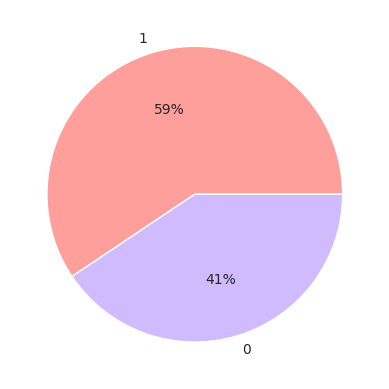

In [ ]:
#my addition to source code
# displays pie chart visualisation of data distribution
plt.pie(data['label'].value_counts(), labels = ['1','0'], colors = sns.color_palette('pastel')[3:5], autopct='%.0f%%' )
plt.show()

# DATA PREPROPRESSING

In [ ]:
#helps in reducing complexity of textual data, removing noise and ensuring consistency which ultimately enhances
#performance by providing cleaner and more structured input data to learn from

In [ ]:
#my addition to source code

def cleaning(txt):
    # Ensure the input is a string
    if not isinstance(txt, str):
        return ""

    # case folding
    text = txt.lower()

    # remove multiple space, tabs, and newlines
    text = re.sub('\s+', ' ', text)

    # remove links
    text = text.replace("http://", " ").replace("https://", " ")

    # remove special characters
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())

    # remove punctuation
    punct = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')  # Define punctuation set
    text = ''.join([word for word in text if word not in punct])

    # remove single character
    text = re.sub(r"\b[a-zA-Z]\b", "", text)

    # remove numbers
    text = re.sub(r"\d+", "", text)

    # remove multiple spaces (again)
    text = re.sub('\s+', ' ', text)

    return text

In [ ]:
#my addition to source code

#apply cleaning function to every text
data['text_cleaned'] = data['text'].apply(lambda x: cleaning(x))
data = data[['text', 'text_cleaned', 'label']]
data.head()

In [ ]:
#my addition to source code
#eliminating unimportant words, allowing model to focus on important words instead

#stopword removal
stop = stopwords.words('english')
data['text_cleaned'] = data['text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [ ]:
#my addition to source code
#strips words back to the root word, using wordnet library.

#Lemmmanization
lemmatizer = WordNetLemmatizer()

# maps parts of speech (POS) tags from "pos_tag" function to the POS tags recognised by the wordnet lemmatizer
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
# takes a string as input, tokenizes it into words and then lemmatizes each word using lemmatizer with appropriate POS tags obtained from
#"get_word_net", then the lemmatized words are joined back to a string
def do_lemma(string):
    lemmatized = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(string)])
    return lemmatized

In [ ]:
#my addition to source code

#test
sentence = "The striped bats are hanging on their feet for best"
lemmatized = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(sentence)])
print(do_lemma(sentence))

In [ ]:
#my addition to source code

data['text_cleaned'] = data['text_cleaned'].apply(lambda x: do_lemma(x))

In [ ]:
data.head()

In [ ]:
#my addition to source code

# we drop the old text column and replace the new cleaned text column as the new main text column
data = data.drop(['text'], axis=1)
data = data.rename(columns = {'text_cleaned' : 'text'})
data.columns

In [ ]:
data.head(10)

# LOADING BERT AND TOKENIZING

In [ ]:
# loading the bert model and its tokenizer
# using uncased for smaller model size and uses words in lowercase
# BERT looks at left and right context of each word
# also uses advanced techniques like WordPiece, splits words into subwords i.e 3
# generates embeddings (numerical representations) that capture the context of words in a sentence.
# The same word can have different embeddings based on its surrounding words, allowing for a richer understanding of language nuances.

from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

In [ ]:
#set model to gpu

model = model.to('cuda')

In [ ]:
#Testing with sample text, output should be in a form of a dictionary, with 3 keys, each outputted as a list of lists

sample_data = ["I am eating","I am playing "]
tokenizer(sample_data, padding=True, truncation=True, max_length=512)

#3 keys :
#input id - token id for each sentence
#token type id - used if there are multiple sentences per input
#attention mask - mask that indicates which tokens the model should pay attention to and which are padding

In [ ]:
# Tokenizing

# set as "list" as the tokenizer expects a list of strings.

X = list(data["text"])
y = list(data["label"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

#split 80% training and 20% validation(testing)(acts as unseen data to evaluate the models performance)

In [ ]:
X_train_tokenized.keys()

#outout should just be : dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(X_train_tokenized['attention_mask'][0])

In [ ]:
len(X_train),len(X_val)

# 14,558 training and 3640 val = 18,198 total dataset records

# CREATING CUSTOM PYTORCH DATASET

In [ ]:
#THIS WAS PART OF THE SOURCE CODE

#To my understanding:

#acts as a contrainer for the preprocessed data, ensuring that the tokenized texts and their corresponding labels are stored
#in a structued format, feeding the data into the model in a consistent and manageable way.

#dataset class is also designed to work directly with the tokenized data, this intergration means the dataset knows how to handle and
#store these tokenized inputs, including attention masks, which are essention for BERT to understand the meaningful parts of the text.

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    # constructor, intialising Dataset object with encodings and labels
    # encodings = dictionary containing tokenized X_train data from the bert tokenizer
    # labels = correspending labels indicating whether a text is toxic or not
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    #fetches individual items (encoded text and its label) by index
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item
    # returns the length of the input ids
    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
#two instances of the Dataset class creacted for training and validation purposes
#these datasets use the tokenized text and their associated labels
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [ ]:
train_dataset[5]

In [ ]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p #takes a tuple containing predictions and actual labels
    pred = np.argmax(pred, axis=1) #uses np.argmax to determine the most likely class label from the predictions
    #then calculates key metrics below:
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# SETTING CLASS WEIGHTS TO HANDLE DATA IMBALANCE

In [ ]:
#random sampling - repeats existing samples
#oversampling - replicates samples from minority class or methods like smote (creates synethic data)
#undersampling - removes samples from majority class

#all the above involve directly altering the dataset, potentially affecting the integrity of the dataset

#i decided to use class weights, which affect the model, not the dataset, thus leaving the dataset as is
#class weights make sure the model pays attention to all examples, but it distributes more weight to the minority class, and less to the
#majority class
#class weights are then passed to a loss function, which helps the model realise if it made a mistake, and penalizes it more for making these
#mistakes because the minority class is lesser than the majority.

In [ ]:
#my addition to source code

# Compute class weights for handling imbalanced dataset

class_weights = compute_class_weight(
    class_weight='balanced', # automatically adjust weights inversely proportional to class frequencies in the input data
    classes=np.unique(y_train), #calculates the unique classes in training label
    y=y_train # training label data, this is used to determine the frequency of each class.
)
# Convert class weights to a tensor
weights = torch.tensor(class_weights, dtype=torch.float) #the class weights are converted into a PyTorch tensor.

In [ ]:
#my addition to source code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


weights = weights.to(device)

In [ ]:
#custom trainer is created in order to pass these calculated weights to a loss function called cross-entropy loss
#cross entropy is useful for classificiation tasks as it compares the predicted probabilities to the actual class labels, there are obviously
#various other loss functions is machine learning, but this one tends to perform well, making it a popular choice in ml

#it is really good at penalising the model when it is confident about the wrong answer. it guides the model to pay attention
#to the minority class and learn from its mistakes effectively.

In [ ]:
#my addition to source code
#Custom trainer that extends the HuggingFace Trainer
#cross entropy loss to handle imbalance data
class CustomTrainer(HfTrainer):

   def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) #calls the contructor of the superclass (HfTrainer) amd sets up an instance variable self.weights.
        self.weights = weights.to(model.device)

   def compute_loss(self, model, inputs, return_outputs=False): # method that overrides the loss computation in the HfTrainer class
        labels = inputs.pop("labels") #extracts the labels from the input data
        outputs = model(**inputs) # passes the remaining inputs to the model and gets the outputs, '**inputs' unpacks the dictionary into keyword arguments
        logits = outputs.logits #extracts the logits from the model outputs
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights) # initialises the cross-entropy loss function with the class weights
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1)) #the loss between the logits and labels reshapes the logits if necessary.
        return (loss, outputs) if return_outputs else loss # if true, returns a tuple of the loss and the outputs, else just returns the loss.

# TESTING TRAINER FOR BEST PARAMETERS

In [ ]:
#too low epochs - underfitting
#too high epochs - overfitting

#lower batch size - enhances generalisation and regularisation, but has long training time
#higher batch size - poorer generalisation if too large, but speeds up training time. 

# important to find the "sweet spot", a good balance

In [ ]:
#random search to find the best parameters for the model

from transformers import Trainer, TrainingArguments
from sklearn.model_selection import ParameterSampler
import numpy as np
import os
import datetime

output_dir = "output/{}".format(datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
os.makedirs(output_dir, exist_ok=True)

# Define a grid of hyperparameters to search over
param_grid = {
    'learning_rate': [1e-5, 2e-5, 5e-5],
    'num_train_epochs': [2, 3, 4, 5, 10],
    'per_device_train_batch_size': [8, 16, 32]
}

# Create a sampler to randomly sample from the grid
param_sampler = ParameterSampler(param_grid, n_iter=10, random_state=0)

best_loss = np.inf
best_params = {}

for params in param_sampler:
    print(f"Training with parameters: {params}")
    args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=params['learning_rate'],
        num_train_epochs=params['num_train_epochs'],
        per_device_train_batch_size=params['per_device_train_batch_size'],
        evaluation_strategy="epoch",
        save_strategy="epoch",  # Save at the end of each epoch
        logging_dir=f'{output_dir}/logs',  # Where to store logs
        logging_steps=10,  # Log every 10 steps
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    if eval_results['eval_loss'] < best_loss:
        best_loss = eval_results['eval_loss']
        best_params = params
        # Save the best model
        model.save_pretrained(f"{output_dir}/best_model")

print(f"Best parameters: {best_params} with loss: {best_loss}")


In [ ]:
#choosing high parameters and letting the training stop with early stopping


# TrainingArguments
import os
import datetime

# Clear the output directory or create a unique directory for the new run
output_dir = "output/{}".format(datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
os.makedirs(output_dir, exist_ok=True)

args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=30,  # You can set this higher since early stopping will halt the training
    per_device_train_batch_size=32,  # Adjust based on your dataset and GPU memory
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save at the end of each epoch
    logging_dir=f'{output_dir}/logs',  # Where to store logs
    logging_steps=10,  # Log every 10 steps
    load_best_model_at_end=True,  # Whether to load the best model found at each evaluation.
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stop if no improvement after 3 epochs
)

# DEFINE PRIMARY TRAINER AND REQUIRED ARGUMENTS

In [ ]:
#my addition to source code

# TrainingArguments
import os
import datetime

# Clear the output directory or create a unique directory for the next run
output_dir = "output/{}".format(datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
os.makedirs(output_dir, exist_ok=True)


args = TrainingArguments(
    output_dir="output",
    # learning_rate=5e-05,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save at the end of each epoch
    logging_dir=f'{output_dir}/logs',  # Where to store logs
    logging_steps=10,  # Log every 10 steps
)

# Trainer
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [ ]:
trainer.train()

# PLOT LEARNING CURVE

In [ ]:
#my addition to source code

#function for plotting learning curve

def plot_training_history(trainer):
    # Retrieve the logged losses and accuracies from the trainer
    training_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry and 'epoch' in entry]
    validation_losses = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]
    training_accuracies = [entry['eval_accuracy'] for entry in trainer.state.log_history if 'eval_accuracy' in entry]
    # The lengths of training and validation metrics should match the number of epochs
    min_length = min(len(training_losses), len(validation_losses), len(training_accuracies))
    if min_length == 0:
        raise ValueError("No training or validation metrics were recorded.")

    epochs = range(1, min_length + 1)
    training_losses = training_losses[:min_length]
    validation_losses = validation_losses[:min_length]
    training_accuracies = training_accuracies[:min_length]

    # Plotting Loss Graph
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Train Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy Graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracies, label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(trainer)

In [ ]:
trainer.evaluate()

In [ ]:
#to get the array values below to display in correct format
np.set_printoptions(suppress=True)

In [ ]:
text = "That was good point"
# text = "Weekend pe shopping jaane ka plan hai, chalna hai?"
# text = "go to hell"
# text = "oh penchoda"
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model(**inputs)
print(outputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
predictions = predictions.cpu().detach().numpy()
predictions

# GET CONFUSION MATRIX AND CLASSIFICATION REPORT

In [ ]:
#my addition to source code

# Ensure model is in evaluation mode
model.eval()

# Move model to the correct device (CPU or CUDA)
model.to(device)

# Prepare the validation dataset
val_dataset = Dataset(X_val_tokenized, y_val)

# DataLoader for validation set
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Iterate over validation data
for batch in val_loader:
    # Unpack batch and move to the correct device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Forward pass, calculate logit predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    # Store predictions and true labels
    true_labels.extend(label_ids)
    predictions.extend(np.argmax(logits, axis=1))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(true_labels, predictions)
print("Classification Report:\n", class_report)


# SAVE MODEL AS STATE DICTIONARY

In [ ]:
#my addition to source code
torch.save(model.state_dict(), '/content/drive/MyDrive/model_state_dict.pth')